# A glimpse of ChoCo

### Notes on the format of statistics in this notebook

- **Duration**, per score and audio, distplot for each (+ mu and std in text)
- **Type**: proportion of score/audio can be mentioned in text, or table.

- **Identifiers**, mentioned in text -- number, proportion and counts.
- **Composers** and **performers**  -- number, proportion, and counts.
- **No. of annotations** (in total), just mention in text.

#### Per annotation namespace (e.g. key, chord in Harte)

- Annotation type: count, not interesting if separated because many keys-chords would follow the same (can avoid).
- **Annotators**, same as before, mention for how many this is available, possibly mention the top 3.

- **No. of observations** (and **unique**): distplot + reference to mean and std
    - For keys, we can filter out the global, and report for when more are given (to avoid inflating 1s).
- **Observation occurrences** (and **w/o reps**), plot histograms of count with relative freqs as plot annotation.

- **N-grams**, same as before. Maybe use table if this is cluttered by labels.

- Durations of observations, per audio and score separately, distplot of averages.

PS: Some of these annotation statistics may make sense only for chords, and not for keys. We can choose a subset of them for keys.

In [1]:
import os
import sys
import glob
import joblib

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown as md

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "choco"))

from jams_stats import ChoCoAnnotationStats, ChoCoDatasetStats, StatsExtractorState
from utils import stringify_dict

# Choose plotting style
sns.set_style("whitegrid")
sns.set_style("darkgrid")

In [2]:
from collections import Counter

def plot_counter(cnt:Counter, name:str, horizontal=False, show_pcts=True,
    first_n=100, title="", ax=None, figsize=(10, 4)):

    fig, ax = plt.subplots(figsize=figsize) if ax is None else (None, ax)

    truncated_cnt = cnt.most_common()[:first_n]
    count_df = pd.DataFrame(truncated_cnt, columns=[name, "count"])
    pcts = round(count_df["count"] / sum(cnt.values()), 2)

    x, y = (name, "count") if not horizontal else ("count", name)
    ax = sns.barplot(x=x, y=y, data=count_df, ax=ax)

    if show_pcts:  # plot percentages as relative counts
        ax.bar_label(ax.containers[0], pcts, label_type='center')
    ax.set_title(title)
    
    return ax


def plot_histogram(values:list, unit:str, title="", ax=None, figsize=(10, 4)):
    
    fig, ax = plt.subplots(figsize=figsize) if ax is None else (None, ax)
    sns.histplot(values, kde=True, ax=ax)

    ax.set_xlabel(unit)
    ax.set_title(title)

    return ax


def create_ngram_df(ngram_cnt:Counter, name:str, first_n=10):

    ngram_records = ngram_cnt.most_common(first_n)  # get ngram tuples
    ngram_df = []  # holding ngram dictionaries, incrementally
    for ngram_record in ngram_records:
        ngram, cnt = ngram_record
        ngram_df.append({**{f"{name}_{i+1}": c for i, c in enumerate(ngram)},
                         **{"cnt": cnt}})  # append actual ngram count

    ngram_df = pd.DataFrame(ngram_df)
    return ngram_df

In [3]:
jams_stats_file = "../choco-jams/jams_stats.joblib"
dataset_stats_file = "../choco-jams/dataset_stats.joblib"

In [4]:
with open(jams_stats_file, 'rb') as jobfile:
    jams_stats = joblib.load(jobfile)

with open(dataset_stats_file, 'rb') as jobfile:
    data_stats = joblib.load(jobfile)

print(f"{len(jams_stats)} JAMS stats")

20280 JAMS stats


## Meta-stats

In [5]:
no_jams, no_annotations = data_stats.no_processed_elements
annotation_stats = data_stats._annotation_stats_ext

In [6]:
annotations_per_namespace = [f"{extractor.no_processed_elements} {name} annotations" for name, extractor in annotation_stats.items()]

md(f"The dataset contains {no_jams} JAMS files: {len(data_stats._durations['audio']['values'])} audio JAMS and {len(data_stats._durations['score']['values'])} score JAMS.\n"
f"In these ChoCo JAMS files, {no_annotations} different annotations were found: {', '.join(annotations_per_namespace)}.")

The dataset contains 20280 JAMS files: 2283 audio JAMS and 17997 score JAMS.
In these ChoCo JAMS files, 42187 different annotations were found: 4847 chord annotations, 20423 key_mode annotations, 15055 chord_harte annotations, 554 segment_open annotations, 286 beat annotations, 1022 chord_m21_abc annotations.

#### Identifiers

In [7]:
md(f"In total, {data_stats._identifiers['sum']} identifiers were found, which cover {data_stats._identifiers['proportion']*100}% of the dataset.")

In total, 771 identifiers were found, which cover 3.8017751479289945% of the dataset.

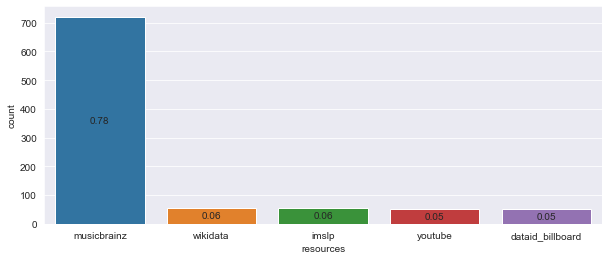

In [8]:
if data_stats._identifiers['sum'] > 0:
    plot_counter(data_stats._identifiers['cnt'], "resources")

#### Durations

In [9]:
md(f"The average duration of audio pieces is {data_stats._durations['audio']['mean']} ± {data_stats._durations['audio']['std']} seconds.\n That of score, instead, is {data_stats._durations['score']['mean']} ± {data_stats._durations['score']['std']} measures.")

# data_stats._durations["audio"]["values"]

The average duration of audio pieces is 191.29056126494467 ± 85.04922784037872 seconds.
 That of score, instead, is 74.74001236163399 ± 82.6568554850611 measures.

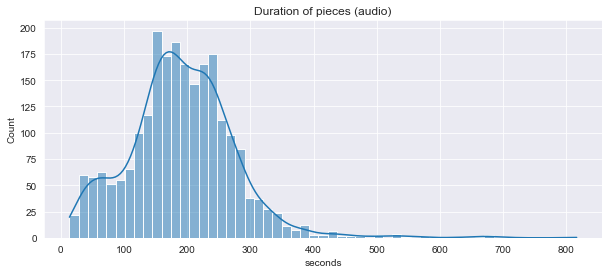

In [10]:
if data_stats._durations['audio']['values'] != []:
    plot_histogram(data_stats._durations['audio']['values'],
        "seconds", title="Duration of pieces (audio)")

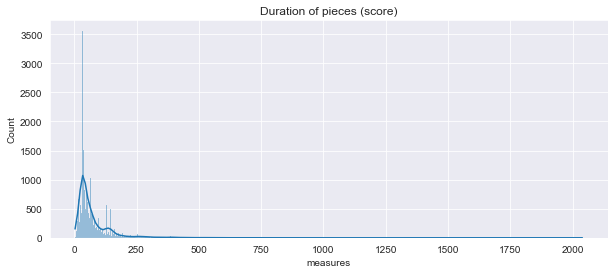

In [11]:
if data_stats._durations['score']['values'] != []:
    plot_histogram(data_stats._durations['score']['values'],
        "measures", title="Duration of pieces (score)")

#### Composers and performers

In [12]:
md(f"In the enriched metadata, {data_stats._performers['sum']} performers were found in the JAMS, which covers {data_stats._performers['proportion']*100}% of the whole dataset. Analogously, a total of  {data_stats._composers['sum']} composers were found ({data_stats._composers['proportion']}% coverage).")

In the enriched metadata, 2483 performers were found in the JAMS, which covers 12.243589743589743% of the whole dataset. Analogously, a total of  7478 composers were found (0.36873767258382645% coverage).

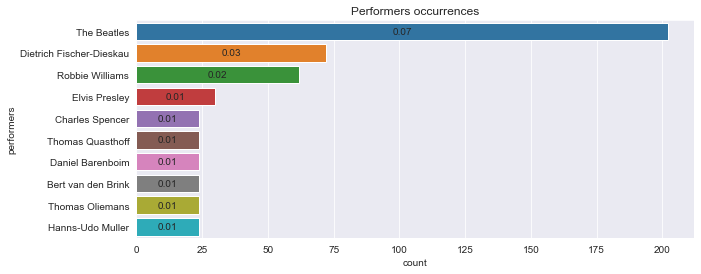

In [13]:
if data_stats._performers['sum'] > 0:
    plot_counter(data_stats._performers["cnt"], "performers", first_n=10,
                title="Performers occurrences", horizontal=True)

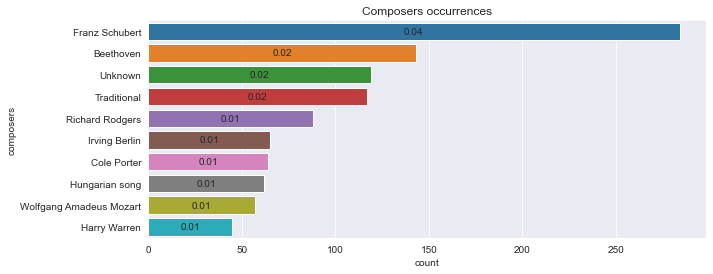

In [14]:
if data_stats._composers['sum'] > 0:
    plot_counter(data_stats._composers["cnt"], "composers", first_n=10,
                title="Composers occurrences", horizontal=True)

## Content-stats


In [15]:
print(f"Choose one of these: {list(annotation_stats.keys())}")

NAMESPACE = "chord"  # the name of the original (or marged)
DESCRIPTION = "chords"

Choose one of these: ['chord', 'key_mode', 'chord_harte', 'segment_open', 'beat', 'chord_m21_abc']


In [16]:
use_merged_chords = True

if use_merged_chords:
    sel_annotations_stats = annotation_stats["chord_harte"]
    sel_annotations_stats.update_annotation_stats(annotation_stats["chord"])
else:  # custom selection from above
    sel_annotations_stats = data_stats._annotation_stats_ext[NAMESPACE]

Merging stats from different namespace: expected namespace chord_harte (this object) but chord was found!


#### Annotators and annotation types

In [17]:
all_annotators =  sum(sel_annotations_stats._annotators['cnt'].values())
real_annotators = sum([c for name, c \
    in sel_annotations_stats._annotators['cnt'].items() if name != "Unknown"])

md(f"Number of annotators for which their identity is known: {real_annotators}, covering {sel_annotations_stats._annotators['proportion']*100}% of {NAMESPACE} annotations.")

Number of annotators for which their identity is known: 996, covering 5.004522158577028% of chord annotations.

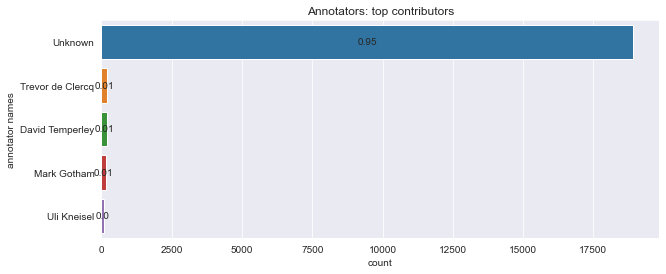

In [18]:
if real_annotators > 0:
    plot_counter(sel_annotations_stats._annotators['cnt'], "annotator names", first_n=5,
                title="Annotators: top contributors", horizontal=True)

#### Observation occurrences

In [19]:
total_occurrences = sum(sel_annotations_stats._no_observations["values"])
total_occurrences_uniq = sum(sel_annotations_stats._no_observations_uniq["values"])

md(f"Overall, there are {total_occurrences} {NAMESPACE} occurrences/observations in the dataset, and an average annotation has {sel_annotations_stats._no_observations['mean']:.2f} ± {sel_annotations_stats._no_observations['std']:.2f} {DESCRIPTION}. When looking at unique occurrences (measuring the diversity of the annotation values), there are {total_occurrences_uniq} unique occurrences. An annotation, on average, uses {sel_annotations_stats._no_observations_uniq['mean']:.2f} ± {sel_annotations_stats._no_observations_uniq['std']:.2f} classes (unique {DESCRIPTION}).")

Overall, there are 1580866 chord occurrences/observations in the dataset, and an average annotation has 79.43 ± 82.42 chords. When looking at unique occurrences (measuring the diversity of the annotation values), there are 305310 unique occurrences. An annotation, on average, uses 15.34 ± 11.22 classes (unique chords).

<AxesSubplot:title={'center':'Number of chord observations in annotations'}, xlabel='chords', ylabel='Count'>

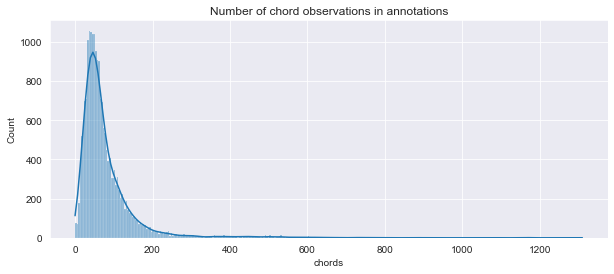

In [20]:

plot_histogram(sel_annotations_stats._no_observations["values"],
    DESCRIPTION, title=f"Number of {NAMESPACE} observations in annotations")

<AxesSubplot:title={'center':'Number of unique chord classes in annotations'}, xlabel='chords', ylabel='Count'>

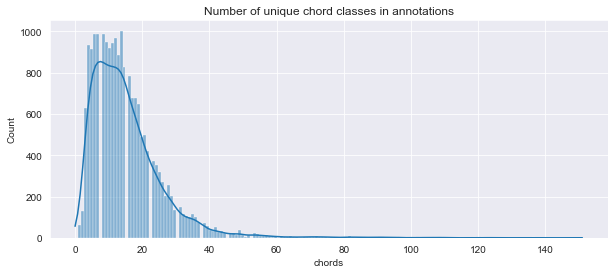

In [21]:

plot_histogram(sel_annotations_stats._no_observations_uniq["values"],
    DESCRIPTION, title=f"Number of unique {NAMESPACE} classes in annotations")

#### Observation values

##### [Observation values] all, with no preprocessing

In [22]:
FIRST_N = 20

# Occurrences of classes accumulated across the whole dataset: as if the dataset
# is a unique annotation (e.g. a very long chord progression)
sel_annotations_stats._observation_cnt_all_abs.most_common(FIRST_N)

[('C:maj', 82906),
 ('G:maj', 70824),
 ('F:maj', 64779),
 ('D:maj', 48808),
 ('G:7', 47336),
 ('C:7', 41459),
 ('Bb:maj', 40105),
 ('A:maj', 39091),
 ('D:7', 36090),
 ('Eb:maj', 30244),
 ('F:7', 28820),
 ('E:maj', 28179),
 ('Bb:7', 26922),
 ('A:min', 25660),
 ('A:7', 25095),
 ('D:min', 22542),
 ('E:min', 20151),
 ('D:min7', 19522),
 ('Ab:maj', 19370),
 ('E:7', 17986)]

In [23]:
# Relative occurrences of classes, first normalised per annotation, then aggregated
sel_annotations_stats._observation_cnt_all_rel.most_common(FIRST_N)

[('C:maj', 5.430860551850583e-06),
 ('G:maj', 4.333181292497664e-06),
 ('F:maj', 4.179204028556294e-06),
 ('G:7', 3.6736567549242164e-06),
 ('C:7', 3.1892871310998924e-06),
 ('D:7', 2.806064897688775e-06),
 ('D:maj', 2.7855309763577354e-06),
 ('Bb:maj', 2.621445024440773e-06),
 ('F:7', 2.2767845120130076e-06),
 ('A:maj', 1.9784461924530994e-06),
 ('Bb:7', 1.976567195278316e-06),
 ('A:7', 1.9333081108161173e-06),
 ('Eb:maj', 1.8748798991575812e-06),
 ('A:min', 1.6878756092242438e-06),
 ('D:min7', 1.5516259885696745e-06),
 ('G:min7', 1.486573663898365e-06),
 ('D:min', 1.3854346922538968e-06),
 ('E:maj', 1.3638811633202953e-06),
 ('E:7', 1.302795743519638e-06),
 ('E:min', 1.231944195229429e-06)]

<AxesSubplot:title={'center':'Relative occurrences of chord classes per annotation'}, xlabel='count', ylabel='chords classes'>

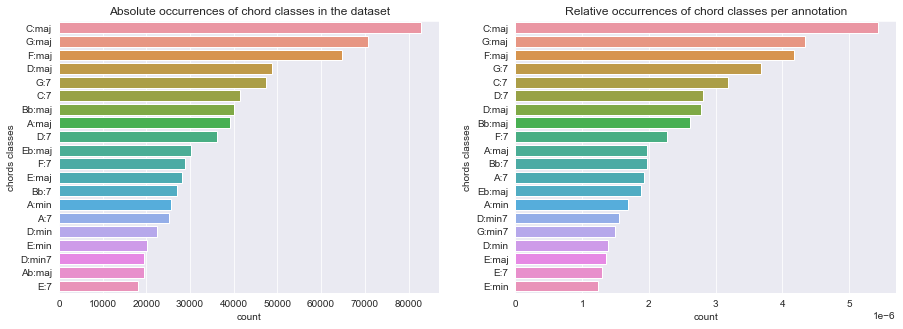

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_all_abs,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} classes in the dataset", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_all_rel,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} classes per annotation", horizontal=True)

##### [Observation values] after removal of consecutively repeated occurrences

In [25]:
sel_annotations_stats._observation_cnt_norep_abs.most_common(FIRST_N)  # Absolute occurrences

[('C:maj', 66351),
 ('G:maj', 56254),
 ('F:maj', 54314),
 ('G:7', 43186),
 ('C:7', 37873),
 ('D:maj', 37773),
 ('Bb:maj', 32842),
 ('D:7', 32465),
 ('A:maj', 30111),
 ('F:7', 25864),
 ('Eb:maj', 25150),
 ('Bb:7', 24710),
 ('A:7', 22666),
 ('A:min', 21573),
 ('E:maj', 19975),
 ('D:min', 18174),
 ('D:min7', 17673),
 ('G:min7', 16971),
 ('E:min', 16671),
 ('E:7', 15790)]

In [26]:
sel_annotations_stats._observation_cnt_norep_rel.most_common(FIRST_N)  # Relative occurrences

[('C:maj', 5.245464192365253e-06),
 ('G:maj', 4.246365283779409e-06),
 ('F:maj', 4.118191604039683e-06),
 ('G:7', 3.725441430349238e-06),
 ('C:7', 3.242136002193059e-06),
 ('D:7', 2.863547505382714e-06),
 ('D:maj', 2.694045209310099e-06),
 ('Bb:maj', 2.569859855337457e-06),
 ('F:7', 2.3184666072152794e-06),
 ('Bb:7', 2.0050803224682306e-06),
 ('A:7', 1.992900842616779e-06),
 ('A:maj', 1.9496252462702334e-06),
 ('Eb:maj', 1.794884103647733e-06),
 ('A:min', 1.6538835421759827e-06),
 ('D:min7', 1.5621389946409164e-06),
 ('G:min7', 1.4936148849264126e-06),
 ('D:min', 1.3616871333052705e-06),
 ('E:7', 1.3351881438919888e-06),
 ('E:maj', 1.2862730937436636e-06),
 ('A:min7', 1.2412568668855218e-06)]

<AxesSubplot:title={'center':'Relative occurrences of chord classes per annotation (no repetitions)'}, xlabel='count', ylabel='chords classes'>

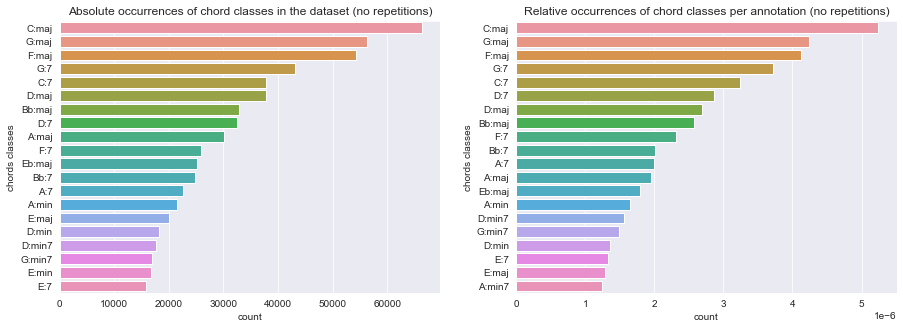

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_norep_abs,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} classes in the dataset (no repetitions)", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_norep_rel,
    f"{DESCRIPTION} classes", first_n=20, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} classes per annotation (no repetitions)", horizontal=True)

##### Duration of observations

In [28]:
md(f"The average duration of {NAMESPACE} observations in audio and score JAMS is: {sel_annotations_stats._observation_dur_avgs['audio']['mean']} ± {sel_annotations_stats._observation_dur_avgs['audio']['std']} seconds and {sel_annotations_stats._observation_dur_avgs['score']['mean']} ± {sel_annotations_stats._observation_dur_avgs['score']['std']} beats.")

The average duration of chord observations in audio and score JAMS is: 2.8500638975751644 ± 12.558620734816389 seconds and nan ± nan beats.

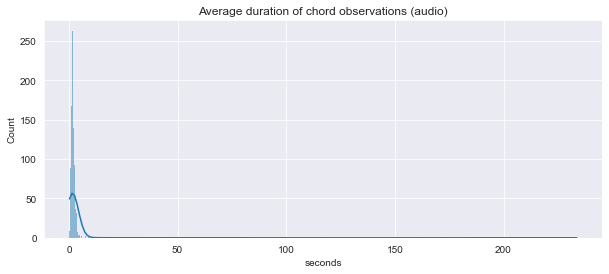

In [29]:
if len(sel_annotations_stats._observation_dur_avgs['audio']["values"]) > 0:
    plot_histogram(sel_annotations_stats._observation_dur_avgs['audio']["values"],
        "seconds", title=f"Average duration of {NAMESPACE} observations (audio)")

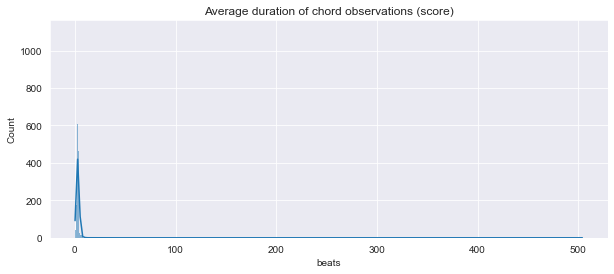

In [30]:
if len(sel_annotations_stats._observation_dur_avgs['score']["values"]) > 0:
    plot_histogram(sel_annotations_stats._observation_dur_avgs['score']["values"],
        "beats", title=f"Average duration of {NAMESPACE} observations (score)")

#### Patterns

##### Patterns: 2-gram

In [31]:
# Absolute occurrences of 2-gram observations
create_ngram_df(sel_annotations_stats._observation_cnt_2g_abs, name=NAMESPACE, first_n=FIRST_N)


,chord_1,chord_2,cnt
0,G:7,C:maj,16275
1,C:7,F:maj,13490
2,G:maj,C:maj,10148
3,C:maj,F:maj,10064
4,D:7,G:maj,9708
5,C:maj,G:maj,9058
6,F:maj,C:maj,8803
7,D:maj,G:maj,8175
8,D:min7,G:7,7982
9,G:maj,D:maj,7749


In [32]:
# Relative occurrences of 2-gram observations
create_ngram_df(sel_annotations_stats._observation_cnt_2g_rel, name=NAMESPACE, first_n=FIRST_N)

,chord_1,chord_2,cnt
0,G:7,C:maj,1.521593e-06
1,C:7,F:maj,1.204874e-06
2,D:7,G:maj,9.218033e-07
3,G:maj,C:maj,8.033600e-07
4,C:maj,F:maj,7.687073e-07
5,C:maj,G:maj,7.411939e-07
6,F:7,Bb:maj,7.339702e-07
7,F:maj,C:maj,7.138060e-07
8,D:min7,G:7,7.041197e-07
9,G:min7,C:7,6.590573e-07


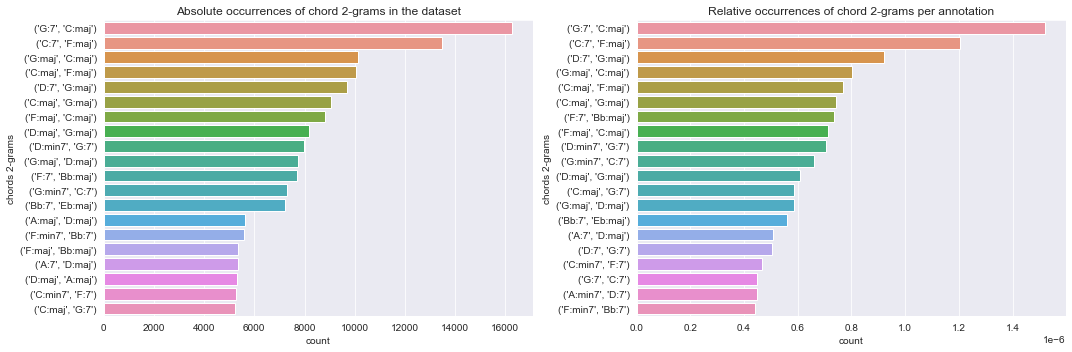

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_2g_abs,
    f"{DESCRIPTION} 2-grams", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} 2-grams in the dataset", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_2g_rel,
    f"{DESCRIPTION} 2-grams", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} 2-grams per annotation", horizontal=True)

plt.tight_layout()

##### Patterns: 3-gram

In [34]:
# Absolute occurrences of 3-gram observations
create_ngram_df(sel_annotations_stats._observation_cnt_3g_abs, name=NAMESPACE, first_n=FIRST_N)


,chord_1,chord_2,chord_3,cnt
0,C:maj,F:maj,C:maj,4265
1,C:maj,G:7,C:maj,4081
2,G:maj,C:maj,G:maj,3749
3,F:maj,C:7,F:maj,3180
4,D:maj,G:maj,D:maj,3075
5,C:maj,G:maj,C:maj,3003
6,F:maj,C:maj,F:maj,2826
7,G:maj,D:7,G:maj,2743
8,G:maj,D:maj,G:maj,2620
9,G:7,C:maj,G:7,2474


In [35]:
# Relative occurrences of 3-gram observations
create_ngram_df(sel_annotations_stats._observation_cnt_3g_rel, name=NAMESPACE, first_n=FIRST_N)

,chord_1,chord_2,chord_3,cnt
0,C:maj,G:7,C:maj,4.874465e-07
1,C:maj,F:maj,C:maj,3.744166e-07
2,G:maj,C:maj,G:maj,3.315605e-07
3,G:maj,D:7,G:maj,3.284568e-07
4,F:maj,C:7,F:maj,3.267776e-07
5,G:7,C:maj,G:7,2.924170e-07
6,C:maj,G:maj,C:maj,2.661146e-07
7,D:maj,G:maj,D:maj,2.598482e-07
8,G:7,C:maj,F:maj,2.302294e-07
9,D:min7,G:7,C:maj,2.152604e-07


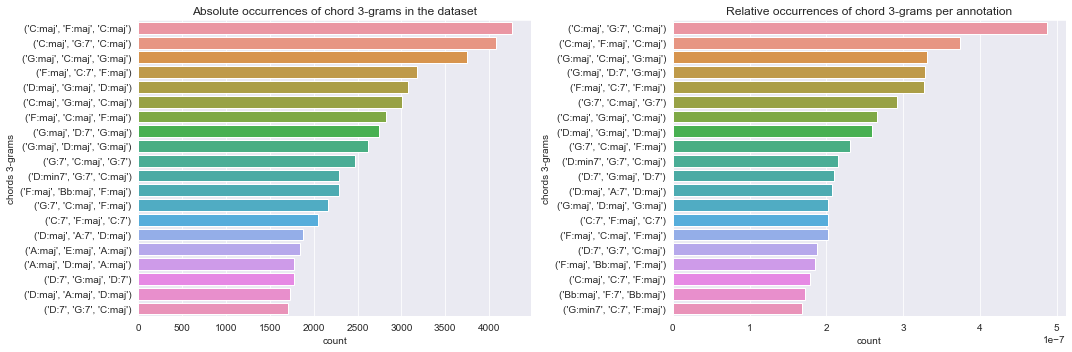

In [36]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_3g_abs,
    f"{DESCRIPTION} 3-grams", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} 3-grams in the dataset", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_3g_rel,
    f"{DESCRIPTION} 3-grams", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} 3-grams per annotation", horizontal=True)

plt.tight_layout()

##### Patterns: 4-grams

In [37]:
# Absolute occurrences of 4-gram observations
create_ngram_df(sel_annotations_stats._observation_cnt_4g_abs, name=NAMESPACE, first_n=FIRST_N)


,chord_1,chord_2,chord_3,chord_4,cnt
0,G:7,C:maj,G:7,C:maj,1972
1,C:maj,F:maj,C:maj,F:maj,1788
2,G:maj,C:maj,G:maj,C:maj,1767
3,C:7,F:maj,C:7,F:maj,1682
4,C:maj,G:maj,C:maj,G:maj,1635
5,F:maj,C:maj,F:maj,C:maj,1627
6,D:maj,G:maj,D:maj,G:maj,1608
7,G:maj,D:maj,G:maj,D:maj,1492
8,D:7,G:maj,D:7,G:maj,1435
9,C:maj,G:7,C:maj,G:7,1279


In [38]:
# Relative occurrences of 4-gram observations
create_ngram_df(sel_annotations_stats._observation_cnt_4g_abs, name=NAMESPACE, first_n=FIRST_N)


,chord_1,chord_2,chord_3,chord_4,cnt
0,G:7,C:maj,G:7,C:maj,1972
1,C:maj,F:maj,C:maj,F:maj,1788
2,G:maj,C:maj,G:maj,C:maj,1767
3,C:7,F:maj,C:7,F:maj,1682
4,C:maj,G:maj,C:maj,G:maj,1635
5,F:maj,C:maj,F:maj,C:maj,1627
6,D:maj,G:maj,D:maj,G:maj,1608
7,G:maj,D:maj,G:maj,D:maj,1492
8,D:7,G:maj,D:7,G:maj,1435
9,C:maj,G:7,C:maj,G:7,1279


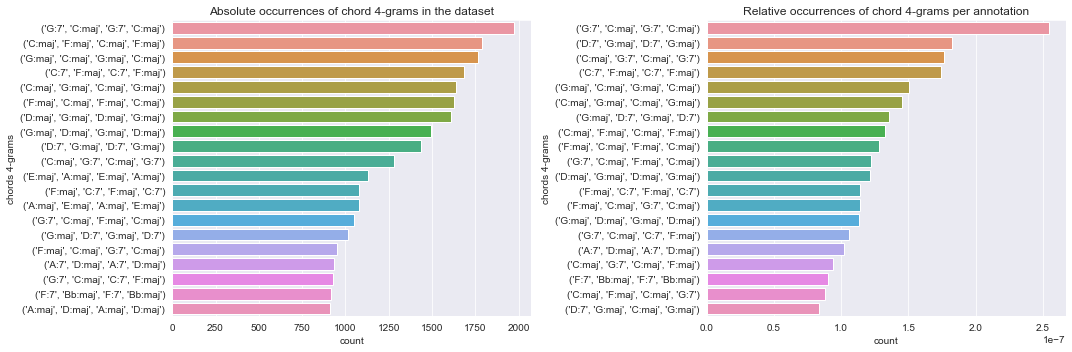

In [39]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

plot_counter(sel_annotations_stats._observation_cnt_4g_abs,
    f"{DESCRIPTION} 4-grams", first_n=FIRST_N, show_pcts=False, ax=ax[0],
    title=f"Absolute occurrences of {NAMESPACE} 4-grams in the dataset", horizontal=True)

plot_counter(sel_annotations_stats._observation_cnt_4g_rel,
    f"{DESCRIPTION} 4-grams", first_n=FIRST_N, show_pcts=False, ax=ax[1],
    title=f"Relative occurrences of {NAMESPACE} 4-grams per annotation", horizontal=True)

plt.tight_layout()